In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import duckdb

sns.set_style()

%load_ext sql
%config SqlMagic.autopandas = True

In [2]:
from src.datasets import daocensus_text, daocensus
# from src.datasets

In [3]:
ORG_NAME = 'Decentraland'
DCT_PATH = Path("./data/daos-census-text")

dfv, dfp = daocensus_text.get(DCT_PATH, ORG_NAME, 'snapshot')
dfv.info()

Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  category      
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 8.5+ MB


In [4]:
dfv_old, dfp_old = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')

In [5]:
print(f'Len dfv_old: {len(dfv_old)}, dfv: {len(dfv)}')
print(f'Len dfp_old: {len(dfp_old)}, dfp: {len(dfp)}, {dfp["id"].nunique()}')

Len dfv_old: 116560, dfv: 116560
Len dfp_old: 1942, dfp: 1943, 1943


Hay propuestas nuevas, pero no tenemos los votos de esas propuestas

In [6]:
new_props = dfp[~dfp['id'].isin(dfp_old['id'])]
new_props

,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,votes_count,title,description,start,end
233,snapshot,Decentraland,snapshot.dcl.eth,d2e7f401-7e51-56f5-84be-6819cdca8034,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,Qme5zXJNfVSPzyiESQMnyx39MaJduX9MZEaTnmQ8Unj8ZR,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-12-03 06:26:25,131,Change the price of claiming a unique name,> by 0xe83fcc89fb8fdd63eb542be01420d24257f28bc...,2021-12-03 06:26:00,2021-12-10 06:26:00


# Exploración del dataset

## Distribución de DAOs en plataformas

In [7]:
db = duckdb.connect(database=':memory:', read_only=False)
db.execute("CREATE VIEW deployments AS SELECT * FROM parquet_scan('{}')".format(DCT_PATH / "raw/deployments.parquet"))
db.execute("CREATE VIEW votes AS SELECT * FROM parquet_scan('{}')".format(DCT_PATH / "raw/votes.parquet"))
db.execute("CREATE VIEW proposals AS SELECT * FROM parquet_scan('{}')".format(DCT_PATH / "raw/proposals.parquet"))

%sql db --alias duckdb

In [8]:
db.execute("SHOW TABLES").fetchdf()

,name
0,deployments
1,proposals
2,votes


In [9]:
%%sql
SHOW TABLES

Running query in 'duckdb'

,name


In [10]:
%%sql dfd_all <<
SELECT *
FROM deployments
LIMIT 100000

Running query in 'duckdb'

31135
\begin{tabular}{lr}
\toprule
{} &      0 \\
platform &        \\
\midrule
aragon   &   2387 \\
daohaus  &   3528 \\
daostack &     58 \\
governor &    885 \\
realms   &   2287 \\
snapshot &  19615 \\
tally    &   2375 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_74867/3783201631.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ndaos.to_latex())


<Axes: xlabel='platform'>

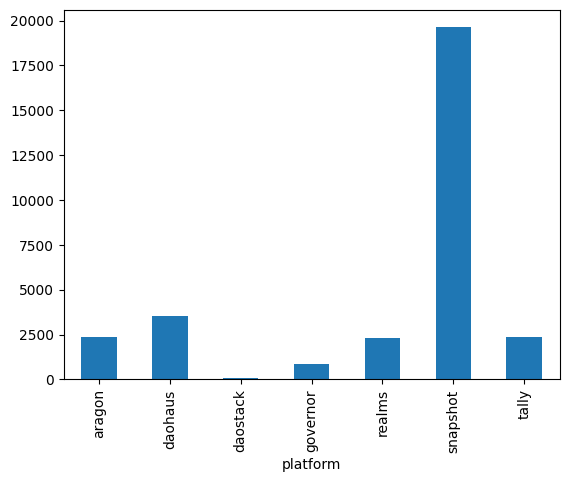

In [11]:
ndaos = dfd_all.groupby('platform').size()
print(ndaos.sum())
print(ndaos.to_latex())
ndaos.plot.bar()

In [12]:
%%sql dfd <<
SELECT *
FROM deployments
WHERE platform IN ('aragon', 'daohaus', 'daostack', 'snapshot')
LIMIT 100000

Running query in 'duckdb'

platform
aragon       2387
daohaus      3528
daostack       58
snapshot    19615
dtype: int64
25588


<Axes: xlabel='platform'>

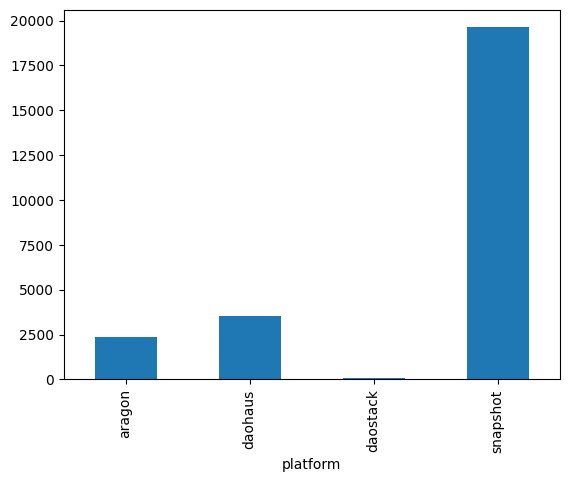

In [13]:
ndaos = dfd.groupby('platform').size()
print(ndaos)
print(ndaos.sum())
ndaos.plot.bar()

## Cantidad total de votos/ etc por plataforma

In [14]:
%%sql dfcnt <<
SELECT * FROM (
    SELECT 
        platform, 
        COUNT(DISTINCT deployments.id) as ndeployments, 
        COUNT(*) as nvotes, 
        COUNT(DISTINCT voter) as nvoters,
    FROM deployments
    LEFT JOIN votes ON (deployments.id = votes.deployment_id)
    GROUP BY platform
)
LEFT JOIN (
    SELECT 
        platform, 
        COUNT(DISTINCT deployments.id) as ndeployments, 
        COUNT(*) AS nproposals
    FROM deployments
    LEFT JOIN proposals ON (deployments.id = proposals.deployment_id)
    GROUP BY platform   
) USING(platform)

Running query in 'duckdb'

In [15]:
display(dfcnt)
print(dfcnt.set_index('platform').sum())

print((dfcnt
    .set_index('platform')[['ndeployments', 'nvotes', 'nvoters', 'nproposals']]
    .sort_index()
    .style
    .format(lambda x: '{:,d}'.format(x).replace(',', ' '))
).to_latex())

,platform,ndeployments,nvotes,nvoters,ndeployments_2,nproposals
0,daostack,58,12331,519,58,3575
1,tally,2375,556988,187976,2375,2375
2,snapshot,19615,20951104,4849174,19615,106504
3,governor,885,413578,84299,885,885
4,aragon,2387,27581,4358,2387,16598
5,daohaus,3528,52033,5816,3528,48866
6,realms,2287,33214,6934,2287,2287


ndeployments         31135
nvotes            22046829
nvoters            5139076
ndeployments_2       31135
nproposals          181090
dtype: int64
\begin{tabular}{lrrrr}
 & ndeployments & nvotes & nvoters & nproposals \\
platform &  &  &  &  \\
aragon & 2 387 & 27 581 & 4 358 & 16 598 \\
daohaus & 3 528 & 52 033 & 5 816 & 48 866 \\
daostack & 58 & 12 331 & 519 & 3 575 \\
governor & 885 & 413 578 & 84 299 & 885 \\
realms & 2 287 & 33 214 & 6 934 & 2 287 \\
snapshot & 19 615 & 20 951 104 & 4 849 174 & 106 504 \\
tally & 2 375 & 556 988 & 187 976 & 2 375 \\
\end{tabular}



## Propuestas con info textual

In [16]:
%%sql dfpall <<
SELECT * 
FROM deployments
LEFT JOIN proposals ON deployments.id = proposals.deployment_id
WHERE platform IN ('aragon', 'daohaus', 'daostack', 'snapshot')

Running query in 'duckdb'

In [17]:
def pctText(group):
    return 1 - pd.isnull(group[['title', 'description']]).any(axis=1).mean()

print(pctText(dfpall))
dfpall.groupby('platform').apply(pctText)

0.6942800339517953


platform
aragon      0.089951
daohaus     0.358695
daostack    0.987692
snapshot    0.932585
dtype: float64

## DAOs relevantes

In [18]:
db.execute("DESCRIBE votes").fetchdf()

,column_name,column_type,null,key,default,extra
0,id,VARCHAR,YES,None,None,NaN
1,proposal_id,VARCHAR,YES,None,None,NaN
2,deployment_id,VARCHAR,YES,None,None,NaN
3,platform_vote_id,VARCHAR,YES,None,None,NaN
4,voter,VARCHAR,YES,None,None,NaN
5,date,TIMESTAMP,YES,None,None,NaN
6,choice,VARCHAR,YES,None,None,NaN
7,weight,"DECIMAL(38,4)",YES,None,None,NaN


In [19]:
%%sql
CREATE OR REPLACE VIEW orgs AS
    WITH G AS (WITH Gv AS (
            SELECT *,
                CASE
                    WHEN name IN ('dxDAO', 'xDXdao') THEN 'dxDAO / xDXdao'
                    WHEN name IN ('Aave', 'Aavegotchi') THEN 'Aave / Aavegotchi'
                    ELSE name
                END AS orgname
            FROM deployments
            LEFT JOIN votes ON (deployments.id = votes.deployment_id)
            -- WHERE platform IN ({platforms})
        )
        SELECT 
            orgname AS name,
            COUNT(DISTINCT Gv.id) AS n_deploys,
            LIST(DISTINCT Gv.id) AS deploys,
            COUNT(DISTINCT Gv.proposal_id) AS proposals_count,
            COUNT(DISTINCT Gv.voter) AS voters_count,
            COUNT(*) AS votes_count,
        FROM Gv
        GROUP BY Gv.orgname
    )
    SELECT
        *,
        proposals_count + voters_count AS nodes,
        2*(votes_count)/((voters_count + proposals_count)*(voters_count + proposals_count-1)) AS density_naive,
        2*(votes_count)/(voters_count*proposals_count) AS density,
        votes_count/proposals_count AS vpp, 
        votes_count/voters_count AS vpv
    FROM G
    ORDER BY proposals_count DESC

Running query in 'duckdb'

,Count


In [20]:
%%sql
SELECT * FROM orgs
LIMIT 100000

Running query in 'duckdb'

,name,n_deploys,deploys,proposals_count,voters_count,votes_count,nodes,density_naive,density,vpp,vpv
0,None,3136,"[bc23ec9c-a8d7-5c93-81ab-1a274ed54f1a, 3381fd2...",9855,2695,20264,12550,0.000257,0.001526,2.056215,7.519109
1,DEAD FoundationsDAO,1,[c37abcdd-a36b-51fc-8fa6-2c3ecb780df0],5591,3469,17738,9060,0.000432,0.001829,3.172599,5.113289
2,PancakeSwap,2,"[e2ec62ae-9b29-5f3a-a541-58678bb64a1b, 1213b93...",2691,129978,532831,132669,0.000061,0.003047,198.004831,4.099394
3,dxDAO / xDXdao,2,"[d3229595-ac4c-55bf-9808-386fc5603bd1, 5deda89...",2226,193,8479,2419,0.002899,0.039472,3.809075,43.932642
4,Decentraland,3,"[41fd8de5-f8e2-5023-86a3-825c49e9ad7f, 36a86d4...",2060,7334,116880,9394,0.002649,0.015473,56.737864,15.936733
...,...,...,...,...,...,...,...,...,...,...,...
25786,awesomeblossom,1,[674b62c7-45c0-5e2f-a614-a1027e9aa649],0,0,1,0,NaN,NaN,NaN,NaN
25787,sdfgdfsgf,1,[2c2a6aeb-ecaf-5d4d-b922-6f0c66a8c5ad],0,0,1,0,NaN,NaN,NaN,NaN
25788,Vesq,1,[490a3ad4-aa21-5d2f-8492-f9b3d9f12d96],0,0,1,0,NaN,NaN,NaN,NaN
25789,defi 8848,1,[258c6134-191e-5df5-9ecb-8c0e7a37d6f0],0,0,1,0,NaN,NaN,NaN,NaN


In [21]:
%%sql
SELECT *
FROM deployments
LEFT JOIN (
    SELECT deployment_id, COUNT(DISTINCT voter) AS nvoters
    FROM votes
    GROUP BY deployment_id
) AS v ON deployments.id = v.deployment_id
LEFT JOIN (
    SELECT deployment_id, COUNT(*) AS nproposals
    FROM proposals
    GROUP BY deployment_id
) AS p ON deployments.id = p.deployment_id
WHERE nvoters >= 3 AND platform IN ('aragon', 'daohaus', 'daostack', 'snapshot')

Running query in 'duckdb'

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count,deployment_id,nvoters,deployment_id_2,nproposals
0,90821c25-4b22-5196-931e-d2cc7a84f608,snapshot,pixelheroes-dao.eth,Pixel Heroes DAO,https://snapshot.org/#/pixelheroes-dao.eth,"pixelheroes_nft, https://www.pixelheroes-dao.com/",883,26,90821c25-4b22-5196-931e-d2cc7a84f608,237,90821c25-4b22-5196-931e-d2cc7a84f608,27.0
1,b25fc076-a1ce-5c43-9787-19c965aa8f80,snapshot,devdao.eth,Developer DAO,https://snapshot.org/#/devdao.eth,"developer_dao, https://www.developerdao.com/",11335,31,b25fc076-a1ce-5c43-9787-19c965aa8f80,2577,b25fc076-a1ce-5c43-9787-19c965aa8f80,34.0
2,ff91a881-b6d4-5e77-89f5-7120d294bf76,snapshot,zyberswap.eth,Zyberswap,https://snapshot.org/#/zyberswap.eth,"zyberswap, https://zyberswap.io",535,4,ff91a881-b6d4-5e77-89f5-7120d294bf76,332,ff91a881-b6d4-5e77-89f5-7120d294bf76,4.0
3,445f982d-0ff9-5100-958e-525b497e4728,snapshot,nexondao.eth,Eralend,https://snapshot.org/#/nexondao.eth,"Era_Lend, https://eralend.com",4738,3,445f982d-0ff9-5100-958e-525b497e4728,2965,445f982d-0ff9-5100-958e-525b497e4728,3.0
4,4cf59f26-54c7-5f06-9729-0217b2c6e814,snapshot,pandaparadise.eth,Panda Paradise DAO,https://snapshot.org/#/pandaparadise.eth,pandaparadiseio,1141,16,4cf59f26-54c7-5f06-9729-0217b2c6e814,497,4cf59f26-54c7-5f06-9729-0217b2c6e814,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8070,11e96eed-b166-5ea1-bb0c-63171a9c4efd,snapshot,dfyn.eth,Dfyn Network,https://snapshot.org/#/dfyn.eth,_DFyn,402,4,11e96eed-b166-5ea1-bb0c-63171a9c4efd,325,11e96eed-b166-5ea1-bb0c-63171a9c4efd,4.0
8071,d34bf9b1-fd9f-54c4-9f97-543bd8484246,snapshot,tradao.eth,Trava Capital,https://snapshot.org/#/tradao.eth,"trava_capital, https://trava.capital/",332,14,d34bf9b1-fd9f-54c4-9f97-543bd8484246,144,d34bf9b1-fd9f-54c4-9f97-543bd8484246,14.0
8072,592ee916-8b1b-56c5-957d-60f6df22e4ef,snapshot,kangal.eth,Kangal,https://snapshot.org/#/kangal.eth,nan,79,11,592ee916-8b1b-56c5-957d-60f6df22e4ef,52,592ee916-8b1b-56c5-957d-60f6df22e4ef,11.0
8073,24ec6c33-8f1a-50e2-8fe9-778fb09fb727,snapshot,massnomis.eth,21Fi,https://snapshot.org/#/massnomis.eth,nan,22,17,24ec6c33-8f1a-50e2-8fe9-778fb09fb727,10,24ec6c33-8f1a-50e2-8fe9-778fb09fb727,17.0


In [22]:
%%sql
SELECT *
FROM deployments
WHERE LOWER(name) LIKE '%aave%'

Running query in 'duckdb'

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count
0,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367
1,377e7181-37e0-504d-b494-d26df613abdc,snapshot,aavegotchi.eth,Aavegotchi,https://snapshot.org/#/aavegotchi.eth,"aavegotchi, https://aavegotchi.com",305499,407
2,73c10c98-7499-53b1-8643-c15d8b5dc5b7,tally,eip155:1:0xEC568fffba86c094cf06b22134B23074DFE...,Aave,nan,nan,19443,194
3,9e321e13-94b7-5414-9c51-f1946a3ee9c4,aragon,0x054086d40cf8fd5bf6200eda7f9c6877b0302dd1,Aavegotchi,https://etherscan.io/address/0x054086d40cf8fd5...,nan,2089,64
4,78c0e836-433c-5c9c-b511-47ece1af2265,aragon,0xc63627255269ddc12de3bee4d7e6526dda59af70,AAVE,https://etherscan.io/address/0xc63627255269ddc...,nan,224,139
5,24dea400-0ae6-5c8b-9a8a-e7688cbfef54,daohaus,0x2d164414dd5fb84281f54f6d3f6f379d8d2e538b,Aave Party Minion Pregame,nan,network: polygon version: 2.1,31,32
6,d8e60168-7f04-52e3-8859-fa988e0bbd5c,daohaus,0xeab0a95854db5853b95aff655b7a3e077f2d2bd1,Aavegotchi Aarcade Developers DAO,nan,network: polygon version: 2.1,4,6
7,db8b9ce6-f5c5-5eb4-9feb-93f5d3508d66,snapshot,iseven.eth,aave,https://snapshot.org/#/iseven.eth,nan,1,1
8,5b2fc3c8-a4e5-5c04-8330-8e780eb053fe,snapshot,aave.joints.eth,AAVEDAO,https://snapshot.org/#/aave.joints.eth,nan,1,1
9,dc1e2511-5926-50e8-bcad-52e93221fa33,snapshot,aave.freesubs.eth,AAVEDAO,https://snapshot.org/#/aave.freesubs.eth,nan,1,1


In [23]:
def best_orgs_for_recsys(
    min_proposals=500, 
    min_voters=100, 
    min_density=0.001, 
    order_by='proposals_count', 
    limit=10000, 
    platforms=['aragon', 'daohaus', 'daostack', 'snapshot'],
):
    platforms = ", ".join(f"'{p}'" for p in platforms)
    df = db.execute(f"""
    SELECT
        *,
    FROM orgs
    WHERE density > {min_density} 
        AND proposals_count > {min_proposals} 
        AND voters_count > {min_voters}
    ORDER BY proposals_count DESC
    LIMIT {limit}
    """).fetchdf().dropna()

    df['milli density'] = 1000 * df['density']

    return df

best_orgs = best_orgs_for_recsys(min_density=0)
best_orgs

,name,n_deploys,deploys,proposals_count,voters_count,votes_count,nodes,density_naive,density,vpp,vpv,milli density
1,DEAD FoundationsDAO,1,[c37abcdd-a36b-51fc-8fa6-2c3ecb780df0],5591,3469,17738,9060,0.000432,0.001829,3.172599,5.113289,1.829114
2,PancakeSwap,2,"[e2ec62ae-9b29-5f3a-a541-58678bb64a1b, 1213b93...",2691,129978,532831,132669,0.000061,0.003047,198.004831,4.099394,3.046744
3,dxDAO / xDXdao,2,"[5deda895-4531-539a-b7dc-88797456ded7, d322959...",2226,193,8479,2419,0.002899,0.039472,3.809075,43.932642,39.472275
4,Decentraland,3,"[7117d5c4-de0e-5e4c-872d-40c3bd4b0200, 41fd8de...",2060,7334,116880,9394,0.002649,0.015473,56.737864,15.936733,15.472556
5,Aave / Aavegotchi,6,"[b6c95a58-d36d-5482-9fa0-fffbbed6e20a, 355c51b...",1140,87593,2360660,88733,0.000600,0.047281,2070.754386,26.950327,47.281276
6,Index Coop,2,"[17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb, a25032f...",874,2871,24032,3745,0.003428,0.019155,27.496568,8.370603,19.154697
7,gm DAO,3,"[c3a8aa6c-1652-5834-a355-954bc422f1af, 4ea69b0...",710,7712,91548,8422,0.002582,0.033439,128.940845,11.870851,33.439016
8,9K DAO,1,[5ecb2cca-8b8a-5c67-8867-569e5ca0a8ae],590,8170,102321,8760,0.002667,0.042454,173.425424,12.523990,42.454204
9,WEALTHDAO,1,[0c40474f-e4a0-540f-ab2f-0451336464f7],585,1041,4008,1626,0.003034,0.013163,6.851282,3.850144,13.162886
10,MetaCartel Ventures,3,"[545d9071-92bc-56c0-853f-1b5add448040, 899cc74...",579,124,2132,703,0.008640,0.059390,3.682211,17.193548,59.390495


In [24]:
cols = {
    'name': 'Nombre',
    'proposals_count': '# Prop.',
    'voters_count': '# Votantes',
    'votes_count': '# Votos',
    'milli density': '‰ Densidad',
    'vpp': 'vpp',
    'vpv': 'vpv',
}

bof = best_orgs[cols.keys()]

style = (bof
    .style
    .format('{:.2f}', subset=bof.select_dtypes('float').columns)
    .format(thousands=' ', subset=bof.select_dtypes('int').columns)
    .relabel_index(list(cols.values()), axis='columns')
    .hide(axis='index')
)
display(style)
print(style.to_latex())

Nombre,# Prop.,# Votantes,# Votos,‰ Densidad,vpp,vpv
DEAD FoundationsDAO,5 591,3 469,17 738,1.83,3.17,5.11
PancakeSwap,2 691,129 978,532 831,3.05,198.00,4.10
dxDAO / xDXdao,2 226,193,8 479,39.47,3.81,43.93
Decentraland,2 060,7 334,116 880,15.47,56.74,15.94
Aave / Aavegotchi,1 140,87 593,2 360 660,47.28,2070.75,26.95
Index Coop,874,2 871,24 032,19.15,27.50,8.37
gm DAO,710,7 712,91 548,33.44,128.94,11.87
9K DAO,590,8 170,102 321,42.45,173.43,12.52
WEALTHDAO,585,1 041,4 008,13.16,6.85,3.85
MetaCartel Ventures,579,124,2 132,59.39,3.68,17.19


\begin{tabular}{lrrrrrr}
Nombre & # Prop. & # Votantes & # Votos & ‰ Densidad & vpp & vpv \\
DEAD FoundationsDAO & 5 591 & 3 469 & 17 738 & 1.83 & 3.17 & 5.11 \\
PancakeSwap & 2 691 & 129 978 & 532 831 & 3.05 & 198.00 & 4.10 \\
dxDAO / xDXdao & 2 226 & 193 & 8 479 & 39.47 & 3.81 & 43.93 \\
Decentraland & 2 060 & 7 334 & 116 880 & 15.47 & 56.74 & 15.94 \\
Aave / Aavegotchi & 1 140 & 87 593 & 2 360 660 & 47.28 & 2070.75 & 26.95 \\
Index Coop & 874 & 2 871 & 24 032 & 19.15 & 27.50 & 8.37 \\
gm DAO & 710 & 7 712 & 91 548 & 33.44 & 128.94 & 11.87 \\
9K DAO & 590 & 8 170 & 102 321 & 42.45 & 173.43 & 12.52 \\
WEALTHDAO & 585 & 1 041 & 4 008 & 13.16 & 6.85 & 3.85 \\
MetaCartel Ventures & 579 & 124 & 2 132 & 59.39 & 3.68 & 17.19 \\
HUWA-DAO & 572 & 1 331 & 4 151 & 10.90 & 7.26 & 3.12 \\
Balancer & 509 & 9 107 & 111 988 & 48.32 & 220.02 & 12.30 \\
\end{tabular}



In [25]:
# all_orgs[all_orgs['name'].str.lower().str.contains('dxdao')]

In [26]:
# all_orgs.sort_values('voters_count', ascending=False).head()

In [27]:
# all_orgs['voters_count'].describe(percentiles=[.5,.72,.9,.94,.99,.993])

In [28]:
# all_orgs['proposals_count'].describe(percentiles=[.5,.96])

In [29]:
# all_orgs['votes_count'].describe(percentiles=[.5,.55, .88, .98])

In [30]:
# best_orgs_for_recsys()